In [1]:
#导入数据
import itertools
import warnings
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')
np.random.seed(100)
#import os
#file_dir=os.getcwd()#获取当前工作目录路径
window=2#时间窗
scale=2000#归一化参数
amount_of_features=1#特征数量
train_file='alic90_131.xls'#file_dir+'\\data\\alic\\alic90_131.xls'#读取训练集地址
test_file='alic132_136.xls'#file_dir+'\\data\\alic\\alic132_136.xls'#读取测试集地址
save_file='alic_predict_arima.csv'#file_dir+'\\data\\alic\\alic_predict_arima.csv'#储存预测值地址

In [2]:
#读取数据，构造训练集和测试集的函数
def read_train(file_name,window,scale):
    #读取数据 
    data=pd.read_excel(file_name,header=None) 
    data=data[1]
    return data
def read_test(file_name,window,scale):
    #读取数据 
    data=pd.read_excel(file_name,header=None) 
    data=data.iloc[:,:]
    data=data[0]
    return data

In [3]:
train=read_train(train_file,window,scale)
test=read_test(test_file,window,scale)
data=pd.concat([train,test])

In [5]:
#用来画残差图 直接调用即可
import statsmodels.tsa.api as smt
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

E:\anoconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\anoconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\anoconda\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
E:\anoconda\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
E:\anoconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 5860.31963 | order: (4, 0, 3)


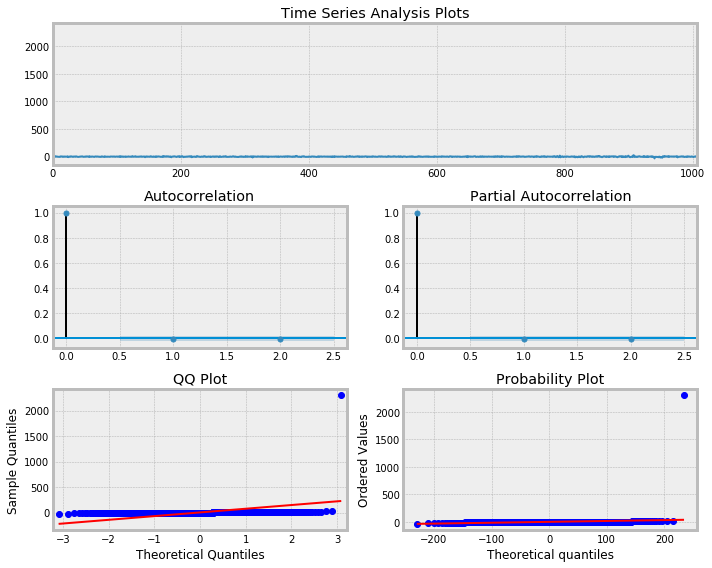

In [8]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(train, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=2)

In [43]:
#展示效果
y_train_predict = best_mdl.predict(start=0)
y_train_predict=y_train_predict.values
y_train_predict=y_train_predict[1:]
y_train = train.values
y_train=y_train[1:]
#在测试集上进行预测
y_test_predict, err95, ci95 = best_mdl.forecast(steps=len(test))
y_test=test.values

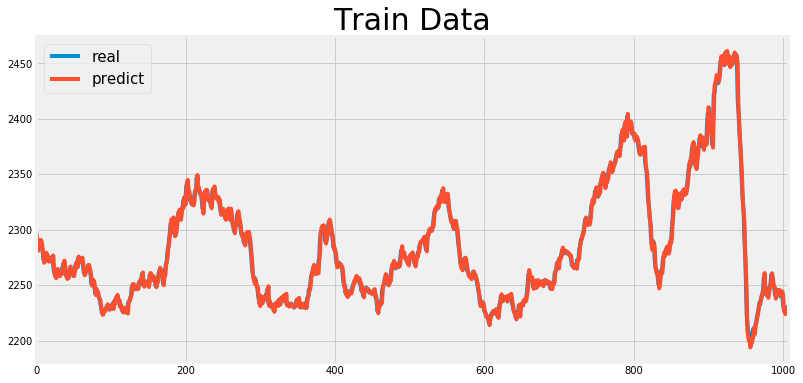

训练集上的MAE/RMSE/MAPE/涨跌准确率
3.2125908368279292
4.365300133551215
0.14001850530016466
0.562624254473161


In [44]:
#以下函数均为对模型进行检验所用到的  精简代码的作用
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
#展示在训练集上的表现 
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
plt.show()
#输出结果
print('训练集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(np.sqrt(mean_squared_error(y_train_predict, y_train)))
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))


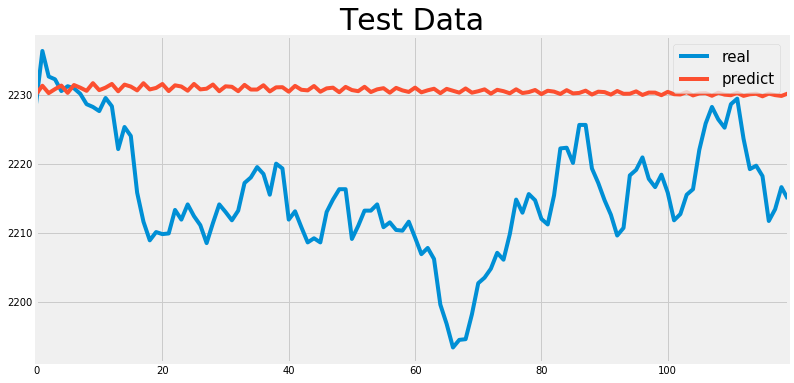

测试集上的MAE/RMSE/MAPE/涨跌准确率
15.095760264445072
17.16109746267598
0.6767609047244222
0.5294117647058824


In [45]:
#展示在测试集上的表现 
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
plt.show()
print('测试集上的MAE/RMSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(np.sqrt(mean_squared_error(y_test_predict, y_test)))
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

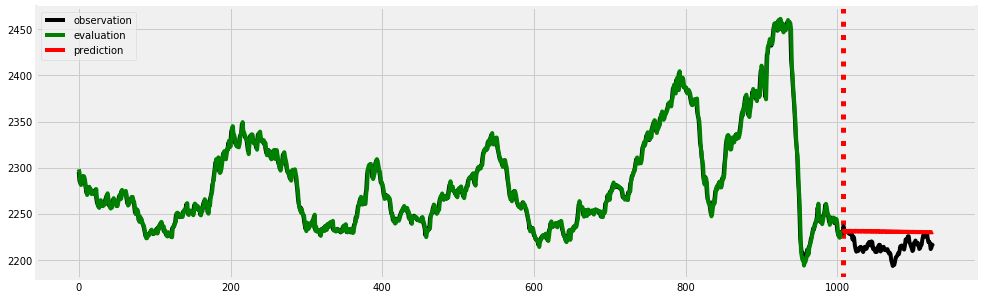

In [46]:
observed=np.hstack((y_train,y_test)) 
evaluated=y_train_predict
predicted=y_test_predict
observed_times=np.arange(len(y_train)+len(y_test))
evaluated_times=np.arange(len(y_train))
predicted_times=np.arange(len(y_train),len(y_train)+len(y_test))
plt.figure(figsize=(15, 5))
plt.axvline(len(y_train), linestyle="dotted", linewidth=5, color='r')
observed_lines = plt.plot(observed_times, observed, label="observation", color="k")
evaluated_lines = plt.plot(evaluated_times, evaluated, label="evaluation", color="g")
predicted_lines = plt.plot(predicted_times, predicted, label="prediction", color="r")

plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],
         loc="upper left")
#为训练，验证，预测数据分别创建图例
plt.show()

In [47]:
#储存文件
(pd.DataFrame(y_test_predict)).to_csv(save_file)